<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 코스피/코스닥 시총 100순위 변동 
- 1주일/1달 주도주 분석
- 상승률 변동 (20, 60, 120, 250) 
- 강한 테마/이슈 뉴스검색어와 분석으로 연속성 검증
- 조회수순? 영향력 강한 1주일 이내 공시 분석기
- 앞으로 상장할 주식 1주일 치 이슈에 부합하나
- 업황 분석기: 지난 1주 1달치 업황 상승률/ 거래대금 순위

In [1]:
!pip install exchange_calendars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import requests
from datetime import datetime, date
import pandas as pd
from io import StringIO
import exchange_calendars as ecals
import FinanceDataReader as fdr

XKRX = ecals.get_calendar("XKRX") # 한국 코드

In [4]:
kospi_df = fdr.DataReader('KS11')
kospi_df['Change'] = kospi_df['Change'] + 1
kospi_df

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1981-05-01,123.60,123.60,123.60,123.60,3330000.0,1.0098
1981-05-02,123.50,123.50,123.50,123.50,2040000.0,0.9992
1981-05-04,120.60,120.60,120.60,120.60,1930000.0,0.9765
1981-05-06,120.70,120.70,120.70,120.70,1690000.0,1.0008
1981-05-07,119.30,119.30,119.30,119.30,1480000.0,0.9884
...,...,...,...,...,...,...
2022-07-13,2328.61,2324.45,2341.19,2312.49,308810000.0,1.0047
2022-07-14,2322.32,2316.41,2338.29,2307.69,349140000.0,0.9973
2022-07-15,2330.98,2335.12,2337.30,2293.45,319680000.0,1.0037


In [5]:
print('mean: ', kospi_df['Change'].mean())
print('var : ', kospi_df['Change'].var())
print('skewness : ', kospi_df['Change'].skew())
print('kurtosis : ', kospi_df['Change'].kurt())

mean:  1.0003758868473713
var :  0.00021209049919068844
skewness :  -0.05604422312768351
kurtosis :  5.502461088840036


In [6]:
import random
import math
import numpy as np

m = kospi_df['Change'].mean()
var = kospi_df['Change'].var()

sample_num = 1000
periods = 250 # 250*40

dates = pd.date_range(start=date.today(), periods=periods)
close_li = [pd.DataFrame({'Change':[random.gauss(m, math.sqrt(var)) for i in range(periods)]}, index=dates) for x in range(sample_num)]
close_li = list(map(lambda x: np.cumprod(x).rename(columns={'Change':'Close'}) * kospi_df['Close'][-1], close_li))

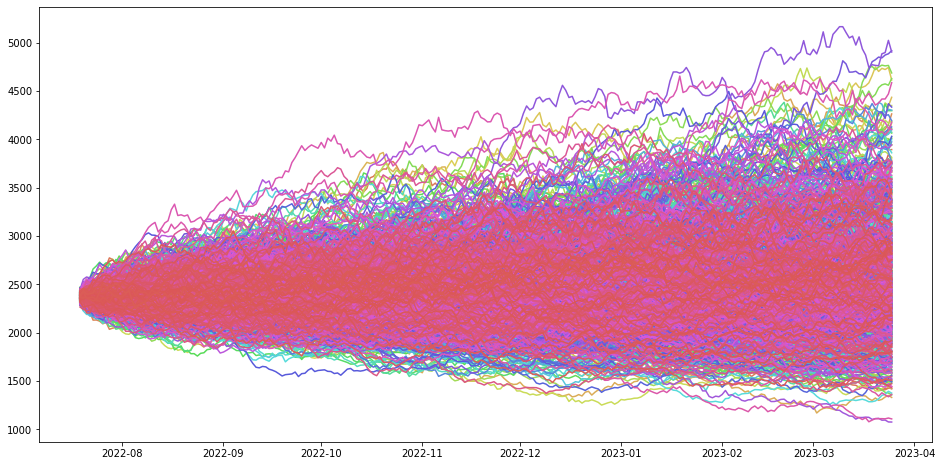

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
colors = list(sns.color_palette("hls", sample_num).as_hex())

for i, j in enumerate(close_li):
  ax.plot(j['Close'], color=colors[i]) #, label=i+1)

plt.show()

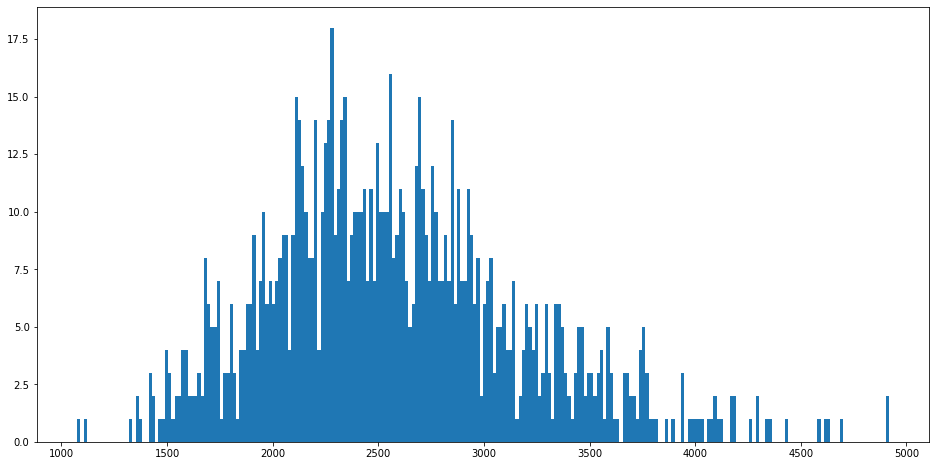

In [8]:
plt.figure(figsize=(16, 8))
end_data = [x.iloc[-1].values[0] for x in close_li]
plt.hist(end_data, bins=250)
plt.show()

In [9]:
# 95% 신뢰구간
max95 = np.mean(end_data) + (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
min95 = np.mean(end_data) - (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
print('95% Min: ', round(min95))
print('95% Max: ', round(max95))

# 평균
print('Mean: ', np.mean([round(x.iloc[-1].values[0],0) for x in close_li]))

# 중앙
print('Median: ', np.median([round(x.iloc[-1].values[0],0) for x in close_li]))

95% Min:  2545
95% Max:  2621
Mean:  2582.819
Median:  2517.5


In [10]:
kosdaq_df = fdr.DataReader('KQ11')
kosdaq_df['Change'] = kosdaq_df['Change'] + 1
kosdaq_df

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2001-01-02,557.00,502.50,559.60,502.50,201210.0,1.0593
2001-01-03,569.00,545.80,579.90,539.30,284990.0,1.0215
2001-01-04,615.10,617.70,621.50,609.00,233130.0,1.0810
2001-01-05,625.20,614.50,630.70,602.50,367230.0,1.0164
2001-01-08,650.00,614.90,657.00,614.00,358620.0,1.0397
...,...,...,...,...,...,...
2022-07-13,763.18,751.34,763.73,747.74,896500000.0,1.0165
2022-07-14,766.08,762.54,768.13,757.99,823120000.0,1.0038
2022-07-15,762.39,768.41,769.29,754.33,850290000.0,0.9952


In [11]:
print('mean: ', kosdaq_df['Change'].mean())
print('var : ', kosdaq_df['Change'].var())
print('skewness : ', kosdaq_df['Change'].skew())
print('kurtosis : ', kosdaq_df['Change'].kurt())

mean:  1.0002024967148488
var :  0.00025314413383283746
skewness :  -0.6902974501458098
kurtosis :  6.3260884807824365


In [12]:
m = kosdaq_df['Change'].mean()
var = kosdaq_df['Change'].var()

sample_num = 1000
periods = 250 # 250*40

dates = pd.date_range(start=date.today(), periods=periods)
close_li = 0
close_li = [pd.DataFrame({'Change':[random.gauss(m, math.sqrt(var)) for i in range(periods)]}, index=dates) for x in range(sample_num)]
close_li = list(map(lambda x: np.cumprod(x).rename(columns={'Change':'Close'}) * kosdaq_df['Close'][-1], close_li))

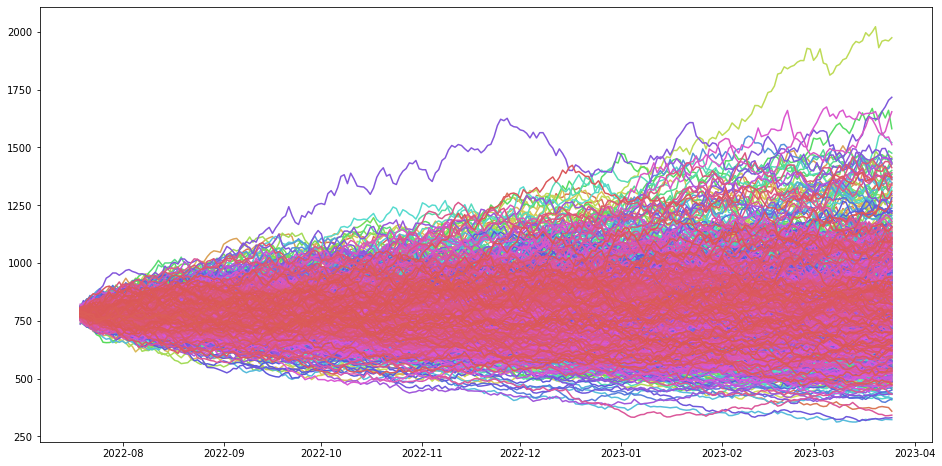

In [13]:
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
colors = list(sns.color_palette("hls", sample_num).as_hex())

for i, j in enumerate(close_li):
  ax.plot(j['Close'], color=colors[i]) #, label=i+1)

plt.show()

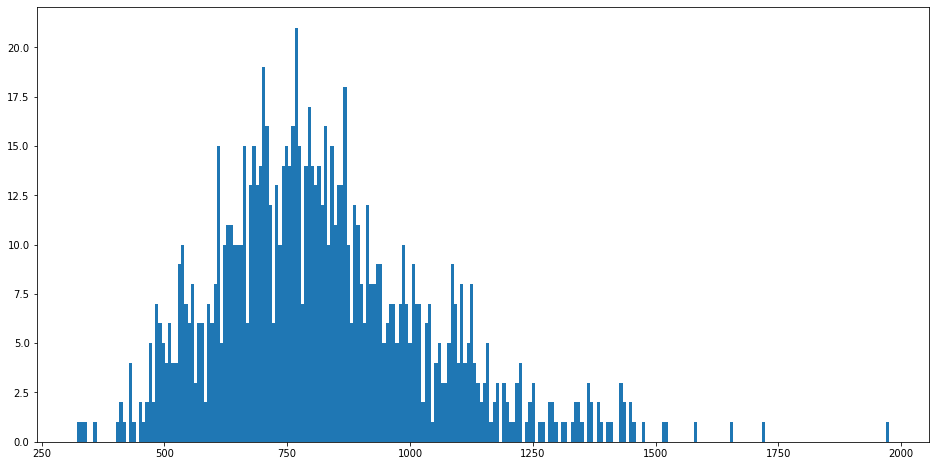

In [14]:
plt.figure(figsize=(16, 8))
end_data = [x.iloc[-1].values[0] for x in close_li]
plt.hist(end_data, bins=250)
plt.show()

In [15]:
# 95% 신뢰구간
max95 = np.mean(end_data) + (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
min95 = np.mean(end_data) - (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
print('95% Min: ', round(min95))
print('95% Max: ', round(max95))

# 평균
print('Mean: ', np.mean([round(x.iloc[-1].values[0],0) for x in close_li]))

# 중앙
print('Median: ', np.median([round(x.iloc[-1].values[0],0) for x in close_li]))

95% Min:  810
95% Max:  837
Mean:  823.035
Median:  795.0


In [16]:
market_type = {
    'all':'ALL',
    'kospi':'STK',
    'kosdaq':'KSQ'
}

def get_ranking(market, ranking_type, start_date, end_date):
  gen_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
  url = ''
  if ranking_type == 'highest': url = 'dbms/MDC/EASY/ranking/MDCEASY01501'
  elif ranking_type == 'traded': url = 'dbms/MDC/EASY/ranking/MDCEASY01601'
  elif ranking_type == 'marketcap': url = 'dbms/MDC/EASY/ranking/MDCEASY01701'
  start_date = start_date.strftime('%Y%m%d') if type(start_date) != str else start_date
  end_date = end_date.strftime('%Y%m%d') if type(end_date) != str else end_date
  data = {
    'locale': 'ko_KR',
    'mktId': market,
    'itmTpCd': '1',
    'itmTpCd2': '1',
    'trdDd': start_date,
    'strtDd': start_date,
    'endDd': end_date,
    'stkprcTpCd': 'Y',
    'share': '1',
    'money': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': url
  }
  gen_key = requests.post(gen_url, data=data).text
  down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
  data = {'code':gen_key}
  r = requests.post(down_url, data=data)
  r.encoding = 'EUC-KR'
  return pd.read_csv(StringIO(r.text))

In [17]:
def get_ranking_df(start='20220613', end='20220712', freq='1D', market='kospi', ranking_type='marketcap'):
  df = pd.DataFrame()
  for d in pd.date_range(start=start, end=end, freq=freq):
    t = pd.DataFrame()
    dt = d
    if XKRX.is_session(dt) == False:
      dt = XKRX.next_open(dt).replace(tzinfo=None)
    t = get_ranking(market_type[market], ranking_type, dt.strftime('%Y%m%d'), dt.strftime('%Y%m%d'))[['순위', '종목명']]
    t['date'] = dt
    df = df.append(t, ignore_index=True)
  return df

In [18]:
# korean font
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip'
!unzip "NotoSansCJKkr-hinted.zip"
!mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/

--2022-07-19 14:34:26--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 173.194.202.128, 2607:f8b0:400e:c00::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip.3’

NotoSansCJKkr-hinte 100%[===================>] 115.55M  95.4MB/s    in 1.2s    

2022-07-19 14:34:27 (95.4 MB/s) - ‘NotoSansCJKkr-hinted.zip.3’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
replace LICENSE_OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKkr-Black.otf  
  inflating: NotoSansCJKkr-Bold.otf  
  inflating: NotoSansCJKkr-DemiLight.otf  
  inflating: NotoSansCJKkr-Light.otf  
  inflating: NotoSansCJKkr-Medium.otf  


In [19]:
from matplotlib import font_manager, rc
font_fname = '/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf'
font_manager.fontManager.addfont(font_fname)
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
font_manager._rebuild()

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

def plot_bump(df='', n_top_ranked=10, title='Title'):
  top_sources = df[df["date"] == df["date"].max()].nsmallest(n_top_ranked, "순위")

  fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(ylim=(0.5, 0.5 + n_top_ranked)))
  #ax.xaxis.set_major_locator(MultipleLocator(1))
  ax.yaxis.set_major_locator(MultipleLocator(1))

  yax2 = ax.secondary_yaxis("right")
  yax2.yaxis.set_major_locator(FixedLocator(top_sources["순위"].to_list()))
  yax2.yaxis.set_major_formatter(FixedFormatter(top_sources["종목명"].to_list()))

  for k, (i, j) in enumerate(df.groupby("종목명")):
    ax.plot("date", "순위", "o-", linewidth=3, markersize=7, data=j, mfc="w")

  ax.invert_yaxis()
  ax.set(xlabel="Date", ylabel="Rank", title=title)
  plt.tight_layout()

In [21]:
from dateutil import relativedelta

t = date.today()
today = t.strftime('%Y%m%d') if XKRX.is_session(t) else XKRX.previous_open(t).replace(tzinfo=None).strftime('%Y%m%d')
w = (date.today() - relativedelta.relativedelta(weeks=1))
previous_week = w.strftime('%Y%m%d') if XKRX.is_session(w) else XKRX.next_open(w).replace(tzinfo=None).strftime('%Y%m%d')
m = (date.today() - relativedelta.relativedelta(months=1))
previous_month = m.strftime('%Y%m%d') if XKRX.is_session(m) else XKRX.next_open(m)
y = (date.today() - relativedelta.relativedelta(years=1))
previous_year = y.strftime('%Y%m%d') if XKRX.is_session(y) else XKRX.next_open(y).replace(tzinfo=None).strftime('%Y%m%d')

Market Cap Ranking Change

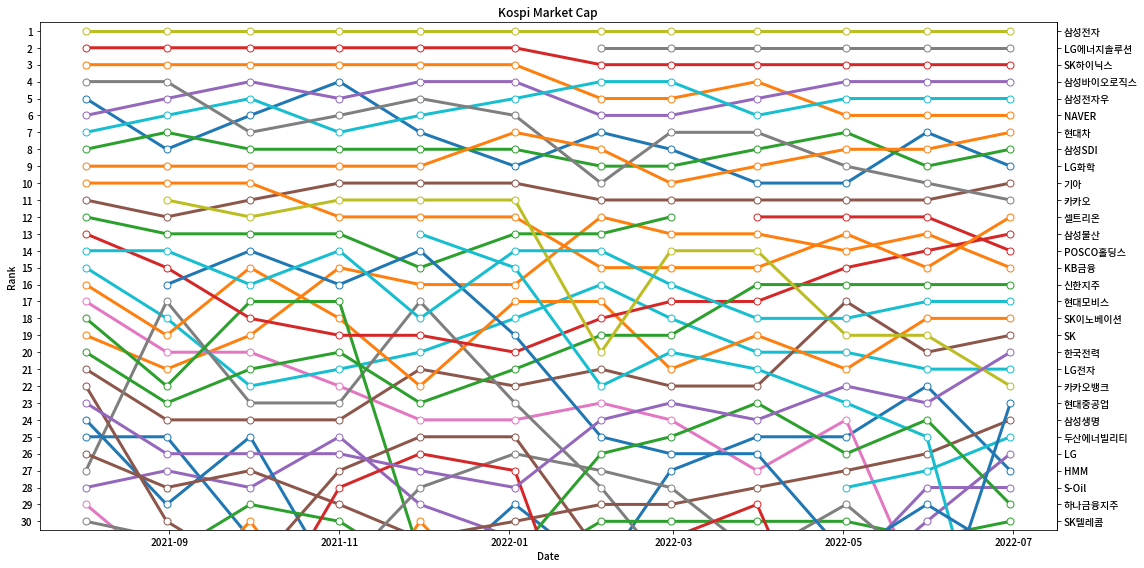

In [22]:
kospi_marketcap_ranking_df = get_ranking_df(previous_year, today, freq='1M', market='kospi', ranking_type='marketcap')
plot_bump(kospi_marketcap_ranking_df, 30, "Kospi Market Cap")

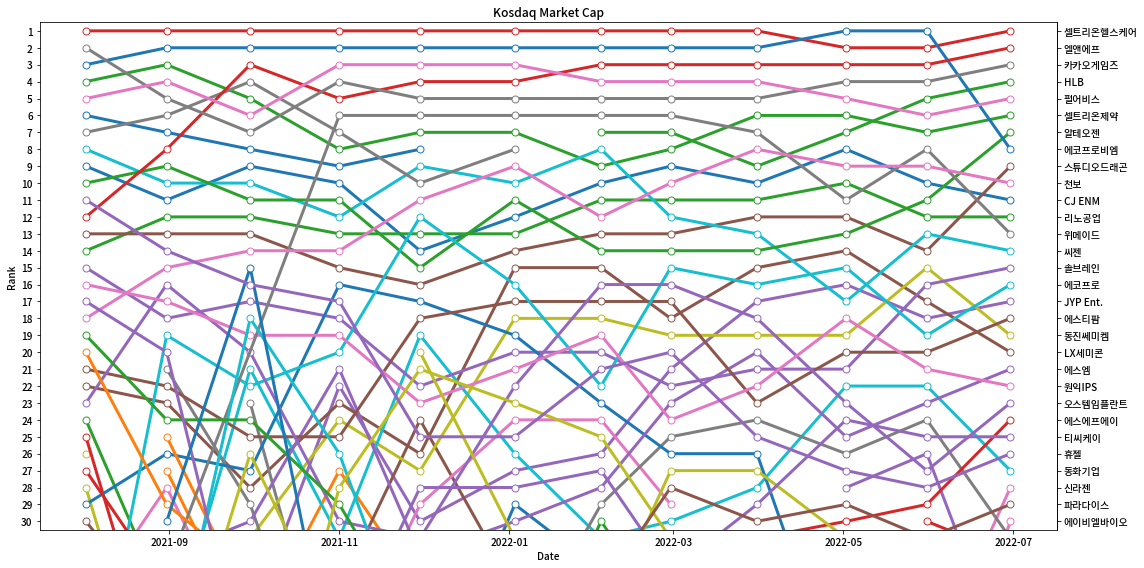

In [23]:
kosdaq_marketcap_ranking_df = get_ranking_df(previous_year, today, freq='1M', market='kosdaq', ranking_type='marketcap')
plot_bump(kosdaq_marketcap_ranking_df, 30, "Kosdaq Market Cap")

Annual King

In [24]:
get_ranking(market_type['kospi'], 'traded', previous_year, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
10,11,249420,일동제약,KOSPI,15750,53400,37650,239.05,769462145,3115231,35145713516200,142290338122
28,29,11700,한신기계,KOSPI,4240,8650,4410,104.01,2130349565,8624897,15255625788865,61763667161
44,45,5070,코스모신소재,KOSPI,38400,53000,14600,38.02,232809177,942547,11112627821250,44990396037
15,16,11070,LG이노텍,KOSPI,241000,328500,87500,36.31,85044222,344309,26763786520227,108355411013
23,24,93370,후성,KOSPI,13050,16900,3850,29.50,881641436,3569399,17616409265200,71321495001
37,38,52690,한전기술,KOSPI,53500,62000,8500,15.89,167851279,679560,13059448178300,52872259831
41,42,10060,OCI,KOSPI,113500,116000,2500,2.20,97660450,395386,11770460694800,47653687023
29,30,17670,SK텔레콤,KOSPI,55557,54000,-1557,-2.80,161028667,651938,14985589946435,60670404641
14,15,270,기아,KOSPI,87100,82100,-5000,-5.74,367762975,1488919,29910687621817,121095901303
25,26,207940,삼성바이오로직스,KOSPI,888479,819000,-69479,-7.82,18364262,74349,15962450137269,64625304199


In [25]:
get_ranking(market_type['kosdaq'], 'traded', previous_year, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
31,32,258830,세종메디칼,KOSDAQ,2090,7360,5270,252.15,1692083654,6850541,10435976448240,42250916794
29,30,5860,한일사료,KOSDAQ,2280,6220,3940,172.81,1642573374,6650095,10818988533285,43801573009
22,23,90710,휴림로봇,KOSDAQ,1065,2775,1710,160.56,5578410617,22584658,13312360595796,53896196744
19,20,53050,지에스이,KOSDAQ,2150,5020,2870,133.49,2969092037,12020616,14193120716932,57462027194
36,37,278650,노터스,KOSDAQ,3131,7210,4079,130.28,591257428,2393755,9195423665860,37228435894
0,1,112040,위메이드,KOSDAQ,28794,61600,32806,113.93,325199169,1316596,40422531347572,163653973067
23,24,307750,국전약품,KOSDAQ,5200,9630,4430,85.19,1131513526,4581026,12615757943930,51075943093
1,2,66970,엘앤에프,KOSDAQ,117000,213600,96600,82.56,209445503,847958,40177610382702,162662390213
16,17,206560,덱스터,KOSDAQ,9540,17000,7460,78.20,719689723,2913724,14845425927250,60102938977
3,4,247540,에코프로비엠,KOSDAQ,66712,110600,43888,65.79,101865800,412412,36309175561219,147000710774


Montly King

In [26]:
get_ranking(market_type['kospi'], 'traded', previous_month, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
5,6,249420,일동제약,KOSPI,36050,53400,17350,48.13,75186271,3417558,3128506809700,142204854986
47,48,11000,진원생명과학,KOSPI,10800,15450,4650,43.06,56284555,2558389,775317447750,35241702170
44,45,4310,현대약품,KOSPI,4400,5930,1530,34.77,137063336,6230152,808796863780,36763493808
2,3,302440,SK바이오사이언스,KOSPI,104000,132500,28500,27.40,32104684,1459304,4153915618700,188814346305
12,13,68270,셀트리온,KOSPI,153000,183500,30500,19.93,11610256,527739,2057552896524,93525131660
42,43,1250,GS글로벌,KOSPI,3205,3825,620,19.34,248485175,11294781,871607194425,39618508838
31,32,51900,LG생활건강,KOSPI,622000,710000,88000,14.15,1595569,72526,1087187136922,49417597133
3,4,5380,현대차,KOSPI,170000,188500,18500,10.88,20093628,913347,3596147222614,163461237392
38,39,12330,현대모비스,KOSPI,202000,219500,17500,8.66,4658498,211750,949114580000,43141571818
9,10,270,기아,KOSPI,76100,82100,6000,7.88,30251689,1375077,2367440113563,107610914253


In [27]:
get_ranking(market_type['kosdaq'], 'traded', previous_month, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
40,41,257720,실리콘투,KOSDAQ,2175,5070,2895,133.10,36006750,1636670,709908332140,32268560552
28,29,258830,세종메디칼,KOSDAQ,3595,7360,3765,104.73,147823775,6719263,899857036650,40902592575
3,4,205470,휴마시스,KOSDAQ,12400,24050,11650,93.95,146308440,6650384,2774255875300,126102539786
41,42,253840,수젠텍,KOSDAQ,10300,18450,8150,79.13,43898574,1995390,709727667510,32260348523
24,25,56700,신화인터텍,KOSDAQ,2460,4360,1900,77.24,253800201,11536373,989037400090,44956245459
36,37,376180,피코그램,KOSDAQ,26100,43100,17000,65.13,21277085,967140,764023749400,34728352245
26,27,84650,랩지노믹스,KOSDAQ,5740,9380,3640,63.41,115439695,5247259,937384376340,42608380743
32,33,950130,엑세스바이오,KOSDAQ,13800,21950,8150,59.06,41986062,1908457,806759471400,36670885064
37,38,102370,케이옥션,KOSDAQ,6969,10750,3781,54.25,38424656,1746575,722306128190,32832096736
19,20,64550,바이오니아,KOSDAQ,24850,37700,12850,51.71,29421475,1337340,1065650936950,48438678952


Weekly King

In [28]:
get_ranking(market_type['kospi'], 'traded', previous_week, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
1,2,249420,일동제약,KOSPI,35450,53400,17950,50.63,44757727,7459621,2130540106100,355090017683
7,8,11000,진원생명과학,KOSPI,11800,15450,3650,30.93,45070775,7511796,655792309450,109298718242
20,21,230,일동홀딩스,KOSPI,30450,39550,9100,29.89,10000157,1666693,350838268800,58473044800
29,30,19170,신풍제약,KOSPI,25650,31500,5850,22.81,10154554,1692426,297804518550,49634086425
28,29,1250,GS글로벌,KOSPI,3440,3825,385,11.19,82096206,13682701,298587220425,49764536738
25,26,12330,현대모비스,KOSPI,201000,219500,18500,9.20,1471023,245171,312072907500,52012151250
48,49,64350,현대로템,KOSPI,18900,20600,1700,8.99,8407113,1401186,164316138350,27386023058
40,41,5070,코스모신소재,KOSPI,48800,53000,4200,8.61,3873833,645639,195823423650,32637237275
2,3,660,SK하이닉스,KOSPI,93700,100000,6300,6.72,19388883,3231481,1888768627300,314794771217
5,6,5380,현대차,KOSPI,179000,188500,9500,5.31,4597937,766323,843827091614,140637848602


In [29]:
get_ranking(market_type['kosdaq'], 'traded', previous_week, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
4,5,258830,세종메디칼,KOSDAQ,4385,7360,2975,67.84,119117994,19852999,788271994050,131378665675
36,37,288980,모아데이타,KOSDAQ,3768,6120,2352,62.42,7556984,1259497,177095070580,29515845097
49,50,52020,에스티큐브,KOSDAQ,7950,12200,4250,53.46,13104239,2184040,137168340180,22861390030
10,11,32300,한국파마,KOSDAQ,28000,39350,11350,40.54,15016507,2502751,553091453250,92181908875
7,8,323990,박셀바이오,KOSDAQ,41700,58300,16600,39.81,10645153,1774192,584984799400,97497466567
25,26,44060,조광ILI,KOSDAQ,2390,3325,935,39.12,37502215,6250369,243196308515,40532718086
0,1,205470,휴마시스,KOSDAQ,18500,24050,5550,30.00,59436458,9906076,1280193756900,213365626150
46,47,7390,네이처셀,KOSDAQ,19000,24450,5450,28.68,7023337,1170556,151587452450,25264575408
39,40,49180,셀루메드,KOSDAQ,4705,5990,1285,27.31,27918698,4653116,162675182240,27112530373
11,12,86520,에코프로,KOSDAQ,69700,88500,18800,26.97,6944179,1157363,550467686300,91744614383


In [30]:
sector_dic = {'에너지': 'WI100', '화학': 'WI110', '비철금속': 'WI200', '철강': 'WI210', '건설': 'WI220', '기계': 'WI230', '조선': 'WI240', '상가,자본재': 'WI250', \
       '운송': 'WI260', '자동차': 'WI300', '화장품,의류': 'WI310', '호텔,레저': 'WI320', '미디어,교육': 'WI330', '소매(유통)': 'WI340', '필수소비재': 'WI400', \
       '건강관리': 'WI410', '은행': 'WI500', '증권': 'WI510', '보험': 'WI520', '소프트웨어': 'WI600', 'IT하드웨어': 'WI610', '반도체': 'WI620', 'IT가전': 'WI630', \
       '디스플레이': 'WI640', '전기통신서비스': 'WI700', '유틸리티': 'WI800'}

sheets = ['Index Value', 'Return', 'Valuation Ratio', 'Risk & Performance Ratio']

In [31]:
def get_sector(sector, term, current_date, pre_year=3):
  id = sector_dic[sector]
  name = 'WI26' + sector
  current_date = current_date if XKRX.is_session(current_date) else XKRX.previous_open(current_date)
  previous_date = (datetime.strptime(current_date, '%Y%m%d') - relativedelta.relativedelta(years=pre_year))
  previous_date = previous_date if XKRX.is_session(previous_date) else XKRX.next_open(previous_date)

  current_date = datetime.strptime(current_date, '%Y%m%d').strftime('%Y-%m-%d') \
  if type(current_date) == str else current_date.strftime('%Y-%m-%d')
  previous_date = datetime.strptime(previous_date, '%Y%m%d').strftime('%Y-%m-%d') \
  if type(previous_date) == str else previous_date.strftime('%Y-%m-%d')
  t = {
      'day' : '1',
      'week' : '2',
      'month' : '3',
      'quarter' : '4'
  }
  headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}
  url = 'https://www.wiseindex.com/DataCenter/ExportToExcel?index_ids=' + \
    id + '&index_names=' + name + '&tabs=1,2,3,4&fromDT=' + \
    previous_date + '&endDT=' + current_date + '&term=' + t[term] + '&isEnd=1'
  res = requests.get(url, headers = headers)
  xls = pd.ExcelFile(res.content)
  return xls

In [32]:
energy = get_sector('에너지', 'month', today, 3)

In [33]:
def get_sheet(elx, sheets):
  df = pd.read_excel(elx, sheets) 
  df.columns = df.iloc[0]
  df = df.iloc[::-1]
  df = df.drop(0)
  df = df[1:].set_index('일자')
  return df

In [34]:
sectors = {}
for sector in list(sector_dic):
  sectors[sector] = get_sheet(get_sector(sector, 'month', today, 3), sheets[0])

Sector Momentum

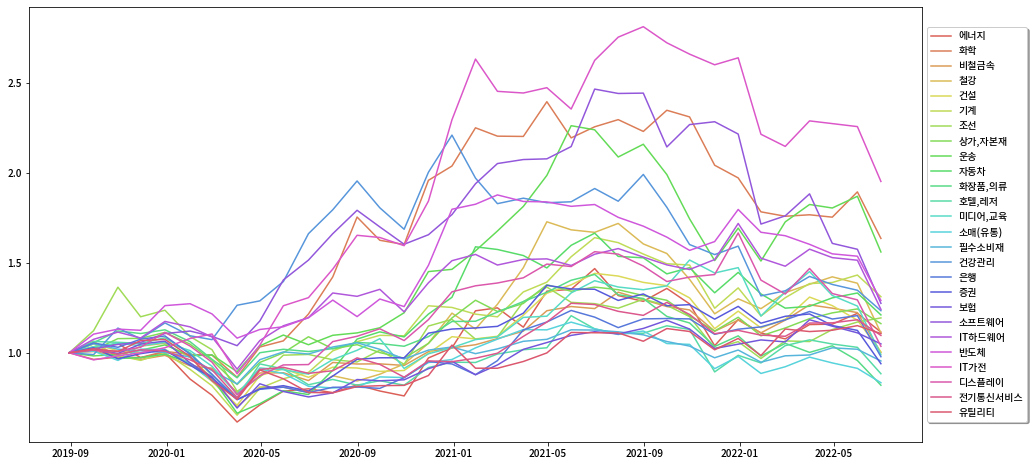

In [35]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
colors = list(sns.color_palette("hls", len(sector_dic)).as_hex())

for i, sector in enumerate(list(sector_dic)):
  ax.plot(sectors[sector]['지수값']/sectors[sector]['지수값'][0], color=colors[i], label=sector)

ax.legend(loc='center left',  bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.show()